# Frequency and time-domain modelling of magnetic sources and receivers


Reproducing Figures 2.2-2.5 and 4.2-4.5 of Ward and Hohmann (1988).

---
---
---

# WARNING - Work in progress

## This is a test-notebook related to an active PR

### See https://github.com/empymod/empymod/pull/45

### `Current` refers to the current version of `empymod`, `New` to the version in the PR.

**To run it, you will need to use the branch of that PR.**

**TODO**: Change title to 5b_MagneticSource_EM.ipynb, because it is FEM and TEM.

---
---
---

Ward and Hohmann (1988), Equations 4.69a and 4.70 (as already shown earlier by Kaufmann and Keller, 1983):

$$
h_z = \frac{m}{4\pi r^3} \left[
         \frac{9}{2\theta^2 r^2} \rm{erf}(\theta r) - \rm{erf}(\theta r) -
         \frac{1}{\pi^{1/2}} \left(\frac{9}{\theta r} + 4\theta r\right)
         \exp(-\theta^2 r^2)
      \right] \, , \qquad (4.69\rm{a})
$$

and

$$
\frac{\partial h_z}{\partial t} = -\frac{m\rho}{2\pi\mu_0 r^5} \left[
         9\rm{erf}(\theta r) -
         \frac{2\theta r}{\pi^{1/2}} \left(9 + 6\theta^2 r^2 + 4\theta^4 r^4\right)
         \exp(-\theta^2 r^2)
      \right] \, , \qquad (4.70)
$$

where

$$
\theta = \sqrt{\frac{\mu_0}{4t\rho}} \, ,
$$

$t$ is time (s), $\rho$ is resistivity ($\Omega\,$m), $r$ is offset (m), and $m$ the magnetic moment (A m^2).

### References

- Kaufmann, A. A., and G. V. Keller, 1983, Frequency and transient soundings: Elsevier, Methods in Geochemistry and Geophysics No. 16; ISBN: 9780444420329.
- Ward, S. H., and G. W. Hohmann, 1988, Electromagnetic theory for geophysical applications, Chapter 4 of Electromagnetic Methods in Applied Geophysics: SEG, Investigations in Geophysics No. 3, 130--311; DOI: https://doi.org/10.1190/1.9781560802631.ch4.

In [1]:
import empymod
import numpy as np
from scipy.special import erf
import matplotlib.pyplot as plt
from scipy.constants import mu_0

In [2]:
%matplotlib notebook
plt.style.use('ggplot')

## Analytical solutions

In [3]:
def hz(t, res, r, m=1.):
    r"""Return equation 4.69a, Ward and Hohmann, 1988.
    
    Switch-off response (i.e., Hz(t)) of a homogeneous isotropic half-space, where
    the vertical magnetic source and receiver are at the interface.
    
    Parameters
    ----------
    t : array
        Times (t)
    res : float
        Halfspace resistivity (Ohm.m)
    r : float
        Offset (m)
    m : float, optional
        Magnetic moment, default is 1.
        
    Returns
    -------
    hz : array
        Vertical magnetic field (A/m)
    
    """
    theta = np.sqrt(mu_0/(4*res*t))
    theta_r = theta*r
    
    s = -(9/theta_r+4*theta_r)*np.exp(-theta_r**2)/np.sqrt(np.pi)
    s += erf(theta_r)*(9/(2*theta_r**2)-1)
    s *= m/(4*np.pi*r**3)
    
    return s


def dhzdt(t, res, r, m=1.):
    r"""Return equation 4.70, Ward and Hohmann, 1988.
    
    Impulse response (i.e., dHz(t)/dt) of a homogeneous isotropic half-space, where
    the vertical magnetic source and receiver are at the interface.
    
    Parameters
    ----------
    t : array
        Times (t)
    res : float
        Halfspace resistivity (Ohm.m)
    r : float
        Offset (m)
    m : float, optional
        Magnetic moment, default is 1.
        
    Returns
    -------
    dhz : array
        Time-derivative of the vertical magnetic field (A/m/s)
    
    """
    theta = np.sqrt(mu_0/(4*res*t))
    theta_r = theta*r
    
    s = (9 + 6 * theta_r**2 + 4 * theta_r**4) * np.exp(-theta_r**2)
    s *= -2 * theta_r /np.sqrt(np.pi)
    s += 9 * erf(theta_r)
    s *= -(m*res)/(2*np.pi*mu_0*r**5)
    
    return s

## Modelling

### Survey parameters

In [4]:
time = np.logspace(-8, 0, 301)

src = [0, 0, 0]
rec = [100, 0, 0]
depth = 0
res = [2e14, 100]

### Analytical result

In [5]:
hz_ana = hz(time, res[1], rec[0])
dhz_ana = dhzdt(time, res[1], rec[0])

### Numerical result

In [6]:
inp = {'src': src, 'rec': rec, 'depth': depth, 'res': res,
       'freqtime': time, 'ab': 66, 'verb': 1,
       'epermH': [0, 0], 'epermV': [0, 0]}  # Reduce early time numerical noise (diffusive approx for air)

hz_num = empymod.dipole(signal=-1, **inp)
dhz_num = empymod.dipole(signal=0, **inp)

hz_num_new = empymod.dipole(signal=-1, **inp, new=True)
dhz_num_new = empymod.dipole(signal=0, **inp, new=True)

### Plot the result

<IPython.core.display.Javascript object>


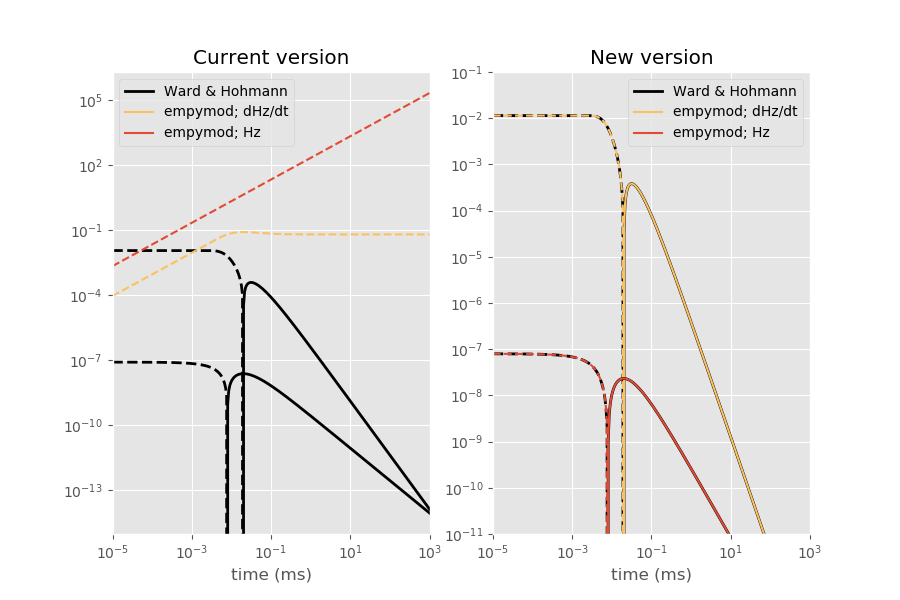

In [7]:
plt.figure(figsize=(9, 6))

plt.subplot(121)
plt.title('Current version')
plt.plot(time*1e3, dhz_ana, 'k-', lw=2, label='Ward & Hohmann')
plt.plot(time*1e3, -dhz_ana, 'k--', lw=2)
plt.plot(time*1e3, dhz_num, 'C4-', label='empymod; dHz/dt')
plt.plot(time*1e3, -dhz_num, 'C4--')

plt.plot(time*1e3, hz_ana, 'k-', lw=2)
plt.plot(time*1e3, -hz_ana, 'k--', lw=2)
plt.plot(time*1e3, hz_num, 'C0-', label='empymod; Hz')
plt.plot(time*1e3, -hz_num, 'C0--')

plt.xscale('log')
plt.yscale('log')
plt.xlim([1e-5, 1e3])
#plt.yticks(10**np.arange(-11., 0))
#plt.ylim([1e-11, 1e-1])
plt.xlabel('time (ms)')
plt.legend()

plt.subplot(122)
plt.title('New version')
plt.plot(time*1e3, dhz_ana, 'k-', lw=2, label='Ward & Hohmann')
plt.plot(time*1e3, -dhz_ana, 'k--', lw=2)
plt.plot(time*1e3, dhz_num_new, 'C4-', label='empymod; dHz/dt')
plt.plot(time*1e3, -dhz_num_new, 'C4--')

plt.plot(time*1e3, hz_ana, 'k-', lw=2)
plt.plot(time*1e3, -hz_ana, 'k--', lw=2)
plt.plot(time*1e3, hz_num_new, 'C0-', label='empymod; Hz')
plt.plot(time*1e3, -hz_num_new, 'C0--')

plt.xscale('log')
plt.yscale('log')
plt.xlim([1e-5, 1e3])
plt.yticks(10**np.arange(-11., 0))
plt.ylim([1e-11, 1e-1])
plt.xlabel('time (ms)')
plt.legend()

plt.show()

### Original Figure
![Original Figure 4.4](figures/WardHohmannFig4-4.png)

## Ward and Hohmann, 1988, Fig 4.2

<IPython.core.display.Javascript object>


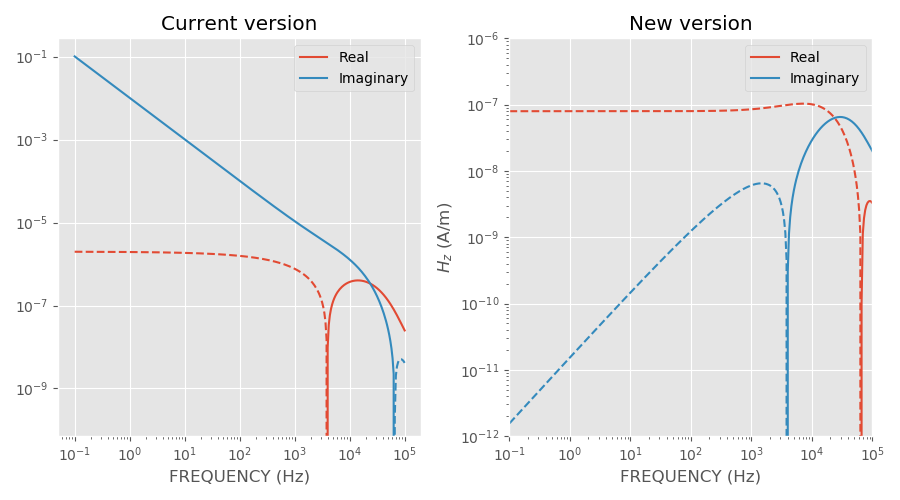

In [8]:
# Survey parameters
freq = np.logspace(-1, 5, 301)
src = [0, 0, 0]
rec = [100, 0, 0]
depth = 0
res = [2e14, 100]
ab = 66  # Vertical magnetic source and receiver


# Calculation
inp = {'src': src, 'rec': rec, 'depth': depth, 'res': res,
       'freqtime': freq, 'ab': ab, 'verb': 1}
fhz_num = empymod.dipole(**inp)
fhz_num_new = empymod.dipole(**inp, new=True)


# Figure
plt.figure(figsize=(9, 5))

plt.subplot(121)
plt.title('Current version')

plt.plot(freq, fhz_num.real, 'C0-', label='Real')
plt.plot(freq, -fhz_num.real, 'C0--')

plt.plot(freq, fhz_num.imag, 'C1-', label='Imaginary')
plt.plot(freq, -fhz_num.imag, 'C1--')

plt.xscale('log')
plt.yscale('log')
#plt.xlim([1e-5, 1e3])
#plt.yticks(10**np.arange(-11., 0))
#plt.ylim([1e-11, 1e-1])
plt.xlabel('FREQUENCY (Hz)')
plt.legend()


plt.subplot(122)
plt.title('New version')

plt.plot(freq, fhz_num_new.real, 'C0-', label='Real')
plt.plot(freq, -fhz_num_new.real, 'C0--')

plt.plot(freq, fhz_num_new.imag, 'C1-', label='Imaginary')
plt.plot(freq, -fhz_num_new.imag, 'C1--')

plt.xscale('log')
plt.yscale('log')
plt.xlim([1e-1, 1e5])
#plt.yticks(10**np.arange(-11., 0))
plt.ylim([1e-12, 1e-6])
plt.xlabel('FREQUENCY (Hz)')
plt.ylabel('$H_z$ (A/m)')
plt.legend()

plt.tight_layout()

plt.show()

![Original Figure 4.2](figures/WardHohmannFig4-2.png)

## Ward and Hohmann, 1988, Fig 4.3

<IPython.core.display.Javascript object>


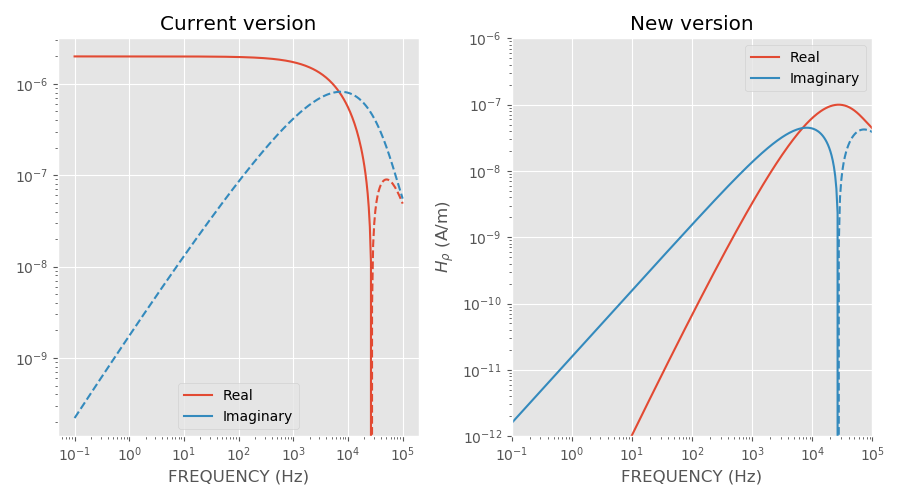

In [9]:
# Survey parameters
freq = np.logspace(-1, 5, 301)
src = [0, 0, 0]
rec = [100, 0, 0]
depth = 0
res = [2e14, 100]
ab = 46  # Vertical magnetic source; horizontal magnetic receiver


# Calculation
inp = {'src': src, 'rec': rec, 'depth': depth, 'res': res,
       'freqtime': freq, 'ab': ab, 'verb': 1}
fhz_num = empymod.dipole(**inp)
fhz_num_new = empymod.dipole(**inp, new=True)


# Figure
plt.figure(figsize=(9, 5))

plt.subplot(121)
plt.title('Current version')

plt.plot(freq, fhz_num.real, 'C0-', label='Real')
plt.plot(freq, -fhz_num.real, 'C0--')

plt.plot(freq, fhz_num.imag, 'C1-', label='Imaginary')
plt.plot(freq, -fhz_num.imag, 'C1--')

plt.xscale('log')
plt.yscale('log')
#plt.xlim([1e-5, 1e3])
#plt.yticks(10**np.arange(-11., 0))
#plt.ylim([1e-11, 1e-1])
plt.xlabel('FREQUENCY (Hz)')
plt.legend()


plt.subplot(122)
plt.title('New version')

plt.plot(freq, fhz_num_new.real, 'C0-', label='Real')
plt.plot(freq, -fhz_num_new.real, 'C0--')

plt.plot(freq, fhz_num_new.imag, 'C1-', label='Imaginary')
plt.plot(freq, -fhz_num_new.imag, 'C1--')

plt.xscale('log')
plt.yscale('log')
plt.xlim([1e-1, 1e5])
#plt.yticks(10**np.arange(-11., 0))
plt.ylim([1e-12, 1e-6])
plt.xlabel('FREQUENCY (Hz)')
plt.ylabel(r'$H_{\rho}$ (A/m)')
plt.legend()

plt.tight_layout()

plt.show()

![Original Figure 4.3](figures/WardHohmannFig4-3.png)

## Ward and Hohmann, 1988, Fig 4.5

<IPython.core.display.Javascript object>


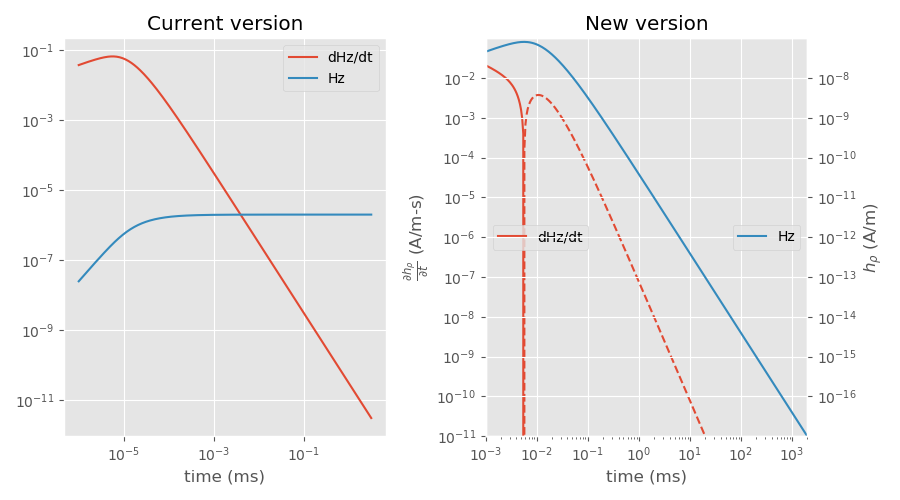

In [10]:
# Survey parameters
time = np.logspace(-6, 0.5, 301)
src = [0, 0, 0]
rec = [100, 0, 0]
depth = 0
res = [2e14, 100]
ab = 46  # Vertical magnetic source; horizontal magnetic receiver


# Calculation
inp = {'src': src, 'rec': rec, 'depth': depth, 'res': res,
       'epermH': [0, 0], 'epermV': [0, 0],  # Reduce early time numerical noise (diffusive approx for air)
       'freqtime': time, 'ab': ab, 'verb': 1}
fhz_num = empymod.dipole(signal=1, **inp)
fhz_num_new = empymod.dipole(signal=1, **inp, new=True)
fdhz_num = empymod.dipole(signal=0, **inp)
fdhz_num_new = empymod.dipole(signal=0, **inp, new=True)


# Figure
plt.figure(figsize=(9, 5))
plt.subplot(121)
plt.title('Current version')

plt.plot(time, fdhz_num, 'C0-', label='dHz/dt')
plt.plot(time, -fdhz_num, 'C0--')

plt.plot(time, fhz_num, 'C1-', label='Hz')
plt.plot(time, -fhz_num, 'C1--')

plt.xscale('log')
plt.yscale('log')
#plt.xlim([1e-5, 1e3])
#plt.yticks(10**np.arange(-11., 0))
#plt.ylim([1e-11, 1e-1])
plt.xlabel('time (ms)')
plt.legend()


ax2 = plt.subplot(122)
plt.title('New version')

plt.plot(time*1e3, fdhz_num_new, 'C0-', label='dHz/dt')
plt.plot(time*1e3, -fdhz_num_new, 'C0--')


plt.xscale('log')
plt.yscale('log')
plt.xlim([1e-3, 2e3])
plt.yticks(10**np.arange(-11., -1))
plt.ylim([1e-11, 1e-1])
plt.xlabel('time (ms)')
plt.ylabel(r'$\frac{\partial h_{\rho}}{\partial t}$ (A/m-s)')
plt.legend(loc=6)


ax3 = ax2.twinx()

plt.plot(time*1e3, fhz_num_new, 'C1-', label='Hz')
plt.plot(time*1e3, -fhz_num_new, 'C1--')

plt.xscale('log')
plt.yscale('log')
plt.xlim([1e-3, 2e3])
plt.yticks(10**np.arange(-16., -7))
plt.ylim([1e-17, 1e-7])
plt.ylabel(r'$h_{\rho}$ (A/m)')
plt.legend(loc=5)

plt.tight_layout()
plt.show()

![Original Figure 4.5](figures/WardHohmannFig4-5.png)

## Ward and Hohmann, 1988, Fig 2.2

<IPython.core.display.Javascript object>


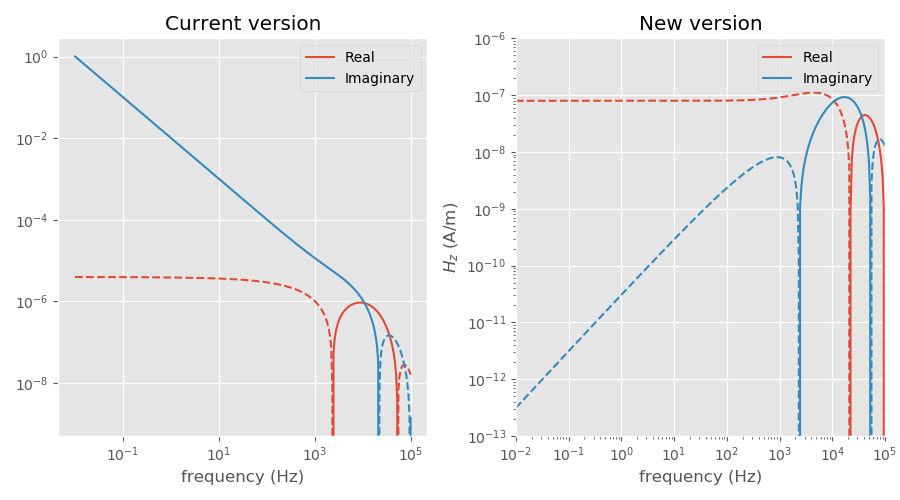

In [11]:
# Survey parameters
freq = np.logspace(-2, 5, 301)
src = [0, 0, 0]
rec = [0, 100, 0]
depth = []
res = 100
ab = 44  # Vertical magnetic source and receiver


# Calculation
inp = {'src': src, 'rec': rec, 'depth': depth, 'res': res,
       'freqtime': freq, 'ab': ab, 'verb': 1}
fhz_num = empymod.dipole(**inp)
fhz_num_new = empymod.dipole(**inp, new=True)


# Figure
plt.figure(figsize=(9, 5))

plt.subplot(121)
plt.title('Current version')

plt.plot(freq, fhz_num.real, 'C0-', label='Real')
plt.plot(freq, -fhz_num.real, 'C0--')

plt.plot(freq, fhz_num.imag, 'C1-', label='Imaginary')
plt.plot(freq, -fhz_num.imag, 'C1--')

plt.xscale('log')
plt.yscale('log')
#plt.xlim([1e-5, 1e3])
#plt.yticks(10**np.arange(-11., 0))
#plt.ylim([1e-11, 1e-1])
plt.xlabel('frequency (Hz)')
plt.legend()


plt.subplot(122)
plt.title('New version')

plt.plot(freq, fhz_num_new.real, 'C0-', label='Real')
plt.plot(freq, -fhz_num_new.real, 'C0--')

plt.plot(freq, fhz_num_new.imag, 'C1-', label='Imaginary')
plt.plot(freq, -fhz_num_new.imag, 'C1--')

plt.xscale('log')
plt.yscale('log')
plt.xlim([1e-2, 1e5])
#plt.yticks(10**np.arange(-11., 0))
plt.ylim([1e-13, 1e-6])
plt.xlabel('frequency (Hz)')
plt.ylabel('$H_z$ (A/m)')
plt.legend()

plt.tight_layout()

plt.show()

![Original Figure 2.2](figures/WardHohmannFig2-2.png)

## Ward and Hohmann, 1988, Fig 2.3

<IPython.core.display.Javascript object>


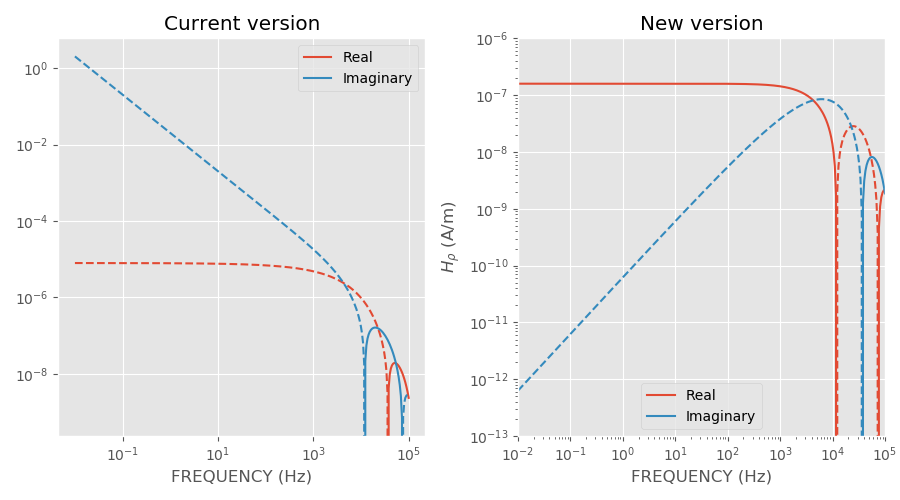

In [12]:
# Survey parameters
freq = np.logspace(-2, 5, 301)
src = [0, 0, 0]
rec = [100, 0, 0]
depth = []
res = 100
ab = 44


# Calculation
inp = {'src': src, 'rec': rec, 'depth': depth, 'res': res,
       'freqtime': freq, 'ab': ab, 'verb': 1}
fhz_num = empymod.dipole(**inp)
fhz_num_new = empymod.dipole(**inp, new=True)


# Figure
plt.figure(figsize=(9, 5))

plt.subplot(121)
plt.title('Current version')

plt.plot(freq, fhz_num.real, 'C0-', label='Real')
plt.plot(freq, -fhz_num.real, 'C0--')

plt.plot(freq, fhz_num.imag, 'C1-', label='Imaginary')
plt.plot(freq, -fhz_num.imag, 'C1--')

plt.xscale('log')
plt.yscale('log')
#plt.xlim([1e-5, 1e3])
#plt.yticks(10**np.arange(-11., 0))
#plt.ylim([1e-11, 1e-1])
plt.xlabel('FREQUENCY (Hz)')
plt.legend()


plt.subplot(122)
plt.title('New version')

plt.plot(freq, fhz_num_new.real, 'C0-', label='Real')
plt.plot(freq, -fhz_num_new.real, 'C0--')

plt.plot(freq, fhz_num_new.imag, 'C1-', label='Imaginary')
plt.plot(freq, -fhz_num_new.imag, 'C1--')

plt.xscale('log')
plt.yscale('log')
plt.xlim([1e-2, 1e5])
#plt.yticks(10**np.arange(-11., 0))
plt.ylim([1e-13, 1e-6])
plt.xlabel('FREQUENCY (Hz)')
plt.ylabel(r'$H_{\rho}$ (A/m)')
plt.legend()

plt.tight_layout()

plt.show()

![Original Figure 2.3](figures/WardHohmannFig2-3.png)

## Ward and Hohmann, 1988, Fig 2.4

<IPython.core.display.Javascript object>


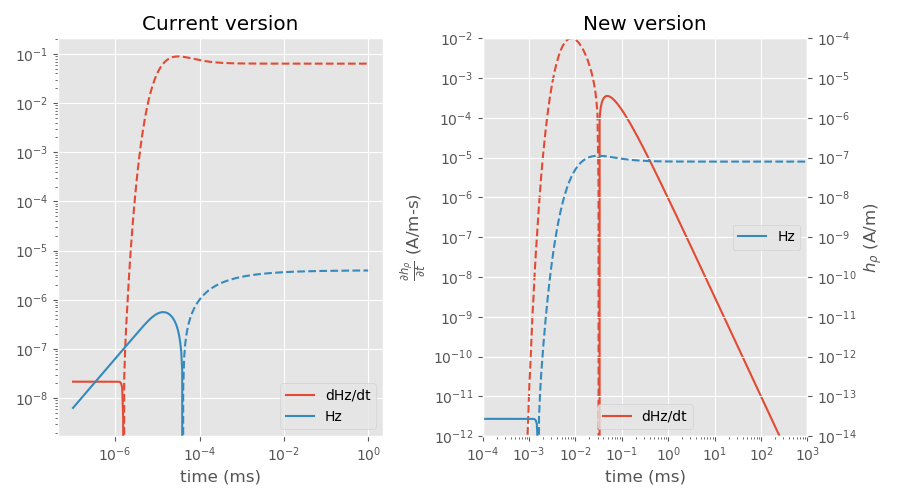

In [13]:
# Survey parameters
time = np.logspace(-7, 0, 301)
src = [0, 0, 0]
rec = [0, 100, 0]
depth = []
res = 100
ab = 44


# Calculation
inp = {'src': src, 'rec': rec, 'depth': depth, 'res': res,
       'xdirect': True, 'freqtime': time, 'ab': ab, 'verb': 1}
fhz_num = empymod.dipole(signal=1, **inp)
fhz_num_new = empymod.dipole(signal=1, **inp, new=True)
fdhz_num = empymod.dipole(signal=0, **inp)
fdhz_num_new = empymod.dipole(signal=0, **inp, new=True)


# Figure
plt.figure(figsize=(9, 5))
plt.subplot(121)
plt.title('Current version')

plt.plot(time, fdhz_num, 'C0-', label='dHz/dt')
plt.plot(time, -fdhz_num, 'C0--')

plt.plot(time, fhz_num, 'C1-', label='Hz')
plt.plot(time, -fhz_num, 'C1--')

plt.xscale('log')
plt.yscale('log')
#plt.xlim([1e-5, 1e3])
#plt.yticks(10**np.arange(-11., 0))
#plt.ylim([1e-11, 1e-1])
plt.xlabel('time (ms)')
plt.legend()


ax2 = plt.subplot(122)
plt.title('New version')

plt.plot(time*1e3, fdhz_num_new, 'C0-', label='dHz/dt')
plt.plot(time*1e3, -fdhz_num_new, 'C0--')


plt.xscale('log')
plt.yscale('log')
plt.xlim([1e-4, 1e3])
plt.yticks(10**np.arange(-12., -1))
plt.ylim([1e-12, 1e-2])
plt.xlabel('time (ms)')
plt.ylabel(r'$\frac{\partial h_{\rho}}{\partial t}$ (A/m-s)')
plt.legend(loc=8)


ax3 = ax2.twinx()

plt.plot(time*1e3, fhz_num_new, 'C1-', label='Hz')
plt.plot(time*1e3, -fhz_num_new, 'C1--')

plt.xscale('log')
plt.yscale('log')
plt.xlim([1e-4, 1e3])
plt.yticks(10**np.arange(-14., -3))
plt.ylim([1e-14, 1e-4])
plt.ylabel(r'$h_{\rho}$ (A/m)')
plt.legend(loc=5)

plt.tight_layout()
plt.show()

![Original Figure 2.4](figures/WardHohmannFig2-4.png)

## Ward and Hohmann, 1988, Fig 2.5

<IPython.core.display.Javascript object>


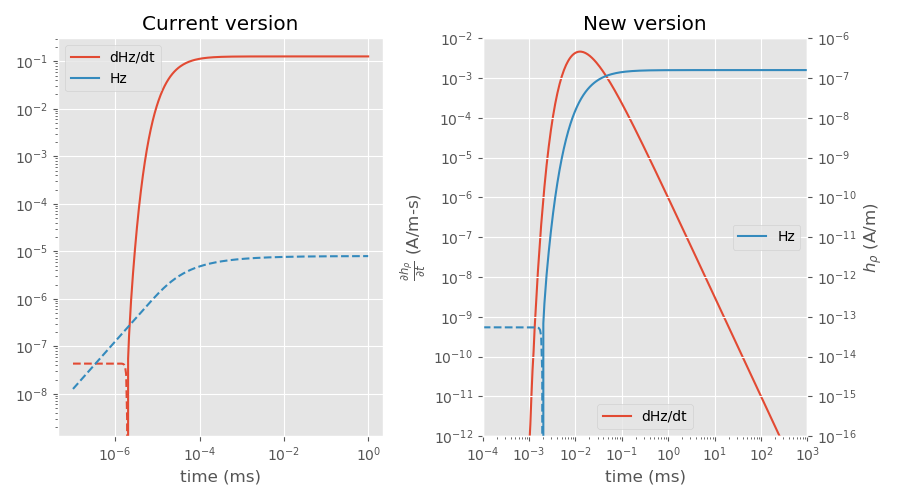

In [14]:
# Survey parameters
time = np.logspace(-7, 0, 301)
src = [0, 0, 0]
rec = [100, 0, 0]
depth = []
res = 100
ab = 44


# Calculation
inp = {'src': src, 'rec': rec, 'depth': depth, 'res': res,
       'xdirect': True, 'freqtime': time, 'ab': ab, 'verb': 1}
fhz_num = empymod.dipole(signal=1, **inp)
fhz_num_new = empymod.dipole(signal=1, **inp, new=True)
fdhz_num = empymod.dipole(signal=0, **inp)
fdhz_num_new = empymod.dipole(signal=0, **inp, new=True)


# Figure
plt.figure(figsize=(9, 5))
plt.subplot(121)
plt.title('Current version')

plt.plot(time, fdhz_num, 'C0-', label='dHz/dt')
plt.plot(time, -fdhz_num, 'C0--')

plt.plot(time, fhz_num, 'C1-', label='Hz')
plt.plot(time, -fhz_num, 'C1--')

plt.xscale('log')
plt.yscale('log')
#plt.xlim([1e-5, 1e3])
#plt.yticks(10**np.arange(-11., 0))
#plt.ylim([1e-11, 1e-1])
plt.xlabel('time (ms)')
plt.legend()


ax2 = plt.subplot(122)
plt.title('New version')

plt.plot(time*1e3, fdhz_num_new, 'C0-', label='dHz/dt')
plt.plot(time*1e3, -fdhz_num_new, 'C0--')


plt.xscale('log')
plt.yscale('log')
plt.xlim([1e-4, 1e3])
plt.yticks(10**np.arange(-12., -1))
plt.ylim([1e-12, 1e-2])
plt.xlabel('time (ms)')
plt.ylabel(r'$\frac{\partial h_{\rho}}{\partial t}$ (A/m-s)')
plt.legend(loc=8)


ax3 = ax2.twinx()

plt.plot(time*1e3, fhz_num_new, 'C1-', label='Hz')
plt.plot(time*1e3, -fhz_num_new, 'C1--')

plt.xscale('log')
plt.yscale('log')
plt.xlim([1e-4, 1e3])
plt.yticks(10**np.arange(-16., -5))
plt.ylim([1e-16, 1e-6])
plt.ylabel(r'$h_{\rho}$ (A/m)')
plt.legend(loc=5)

plt.tight_layout()
plt.show()

![Original Figure 2.5](figures/WardHohmannFig2-5.png)

In [15]:
empymod.Report()

--------------------------------------------------------------------------------
  Date: Thu Oct 10 22:07:19 2019 CEST

             Linux : OS
                 4 : CPU(s)
            x86_64 : Machine
             64bit : Architecture
            7.7 GB : RAM
           Jupyter : Environment

  Python 3.7.4 (default, Aug 13 2019, 20:35:49)  [GCC 7.3.0]

            1.16.5 : numpy
             1.3.1 : scipy
         1.8.4dev0 : empymod
             2.7.0 : numexpr
             7.8.0 : IPython
             3.1.1 : matplotlib

  Intel(R) Math Kernel Library Version 2019.0.5 Product Build 20190808 for
  Intel(R) 64 architecture applications
--------------------------------------------------------------------------------